# CNN training

In [36]:
import os
import re
import random
import datetime
import tensorflow as tf
print("Tensorflow version " + tf.__version__)

import PIL
import numpy as np
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split

from __future__ import print_function
import keras
import keras.preprocessing
from keras.models import Sequential
from keras.utils import to_categorical
from keras.layers import Dense, Conv2D, MaxPooling2D, Dropout, Flatten
from keras.models import load_model
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint

Tensorflow version 2.2.0


In [2]:
os.environ['CUDA_VISIBLE_DEVICES'] = '0'
physical_devices = tf.config.experimental.list_physical_devices('GPU') 
#tf.config.experimental.set_memory_growth(physical_devices[0], True)
physical_devices

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

# Functions

In [3]:
def fileToList(file_name):
    result_list = [] 
    fp = open(file_name)
    for row in fp:
        row = row.strip()
        row = row.replace("\"","")
        row = re.split('\t',row)
        #row = re.split(r'[;,\s]\s*', row)
        result_list.append(row)
    fp.close()  
    return result_list 

In [4]:
def createModel():
    model = Sequential()
    # The first two layers with 32 filters of window size 3x3
    model.add(Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=input_shape))
    model.add(Conv2D(32, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Flatten())
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(nClasses, activation='softmax'))
    
    return model

In [5]:
def showImg(img_data):
    if type(img_data) is list:
        image = tf.keras.preprocessing.image.load_img(img_data)
        plt.imshow(image)
    if type(img_data) is np.ndarray:
        image = tf.keras.preprocessing.image.array_to_img(img_data)
        plt.imshow(image)
        
        

In [6]:
def resizeCropImg(img_file, target_width, target_height):
    image = tf.keras.preprocessing.image.load_img(img_file)
    width, height = image.size
    left   = width*0.13
    top    = height*0.13
    right  = width*0.87
    bottom = height*0.87
    image = image.crop((left, top, right, bottom))
    image = image.resize((target_width, target_height))
    return image

In [7]:
def loadImgs(cnv_list, img_width, img_height):
    cnv_np = np.zeros((len(cnv_list), img_width, img_height, 3))
    for index, each_cnv in enumerate(cnv_list):
        if index % 1000 == 1:
            time_stamp = datetime.datetime.now()
            time_str   = time_stamp.strftime('%Y.%m.%d-%H:%M:%S')
            print("[%s] Processing %d ..."%(time_str, index))
        cnv_img = resizeCropImg(each_cnv, img_width, img_height)
        cnv_np[index] = tf.keras.preprocessing.image.img_to_array(cnv_img)
    time_stamp = datetime.datetime.now()
    time_str   = time_stamp.strftime('%Y.%m.%d-%H:%M:%S')
    print("[%s] Done %d."%(time_str, index))
    return cnv_np

# Variables

In [8]:
img_width, img_height = 224, 224

true_del_file = '/home/rt2776/cnv_espresso/images/true_del_entire_path.list'
false_del_file = '/home/rt2776/cnv_espresso/images/false_del_entire_path.list'

# Processing

### Loading cnv image file paths to list

In [21]:
true_del_list = [each_file[0] for each_file in fileToList(true_del_file)]
false_del_list = [each_file[0] for each_file in fileToList(false_del_file)]
len(true_del_list), len(false_del_list)

(26045, 2551)

### Loading images from list to numpy array

In [10]:
false_del_img_np = loadImgs(false_del_list, img_width, img_height)
false_del_img_np.shape

[2021.01.13-14:26:52] Processing 1 ...
[2021.01.13-14:28:43] Processing 1001 ...
[2021.01.13-14:30:32] Processing 2001 ...
[2021.01.13-14:31:33] Done 2550.


(2551, 224, 224, 3)

In [11]:
true_del_img_np = loadImgs(true_del_list, img_width, img_height)
true_del_img_np.shape

[2021.01.13-14:31:33] Processing 1 ...
[2021.01.13-14:33:28] Processing 1001 ...
[2021.01.13-14:35:17] Processing 2001 ...
[2021.01.13-14:37:07] Processing 3001 ...
[2021.01.13-14:38:58] Processing 4001 ...
[2021.01.13-14:40:48] Processing 5001 ...
[2021.01.13-14:42:35] Processing 6001 ...
[2021.01.13-14:44:19] Processing 7001 ...
[2021.01.13-14:46:04] Processing 8001 ...
[2021.01.13-14:47:49] Processing 9001 ...
[2021.01.13-14:49:33] Processing 10001 ...
[2021.01.13-14:51:18] Processing 11001 ...
[2021.01.13-14:53:03] Processing 12001 ...
[2021.01.13-14:54:50] Processing 13001 ...
[2021.01.13-14:56:35] Processing 14001 ...
[2021.01.13-14:58:24] Processing 15001 ...
[2021.01.13-15:00:08] Processing 16001 ...
[2021.01.13-15:01:55] Processing 17001 ...
[2021.01.13-15:03:40] Processing 18001 ...
[2021.01.13-15:05:26] Processing 19001 ...
[2021.01.13-15:07:12] Processing 20001 ...
[2021.01.13-15:08:57] Processing 21001 ...
[2021.01.13-15:10:45] Processing 22001 ...
[2021.01.13-15:12:36] Pr

(26045, 224, 224, 3)

### Generage labels

In [20]:
true_del_label = [1 for i in range(0,len(true_del_img_np))]
false_del_label = [0 for i in range(0,len(false_del_img_np))]
print(true_del_label[0:5], false_del_label[0:5])
print(len(true_del_label), len(false_del_label))

NameError: name 'true_del_img_np' is not defined

### Combine and shuffle true and false data

In [13]:
del_img = np.vstack((true_del_img_np, false_del_img_np))
del_label = true_del_label + false_del_label

In [14]:
tmp = list(zip(del_img, del_label))
random.shuffle(tmp)
del_img, del_label = zip(*tmp)
del_img_np = np.asarray(del_img)

In [15]:
type(del_img),type(del_img_np)

(tuple, numpy.ndarray)

In [16]:
np.save('/home/rt2776/cnv_espresso/images/del_label', del_label)

In [17]:
np.save('/home/rt2776/cnv_espresso/images/del_img_np', del_img_np)

In [12]:
del_label = np.load('/home/rt2776/cnv_espresso/images/del_label.npy')

In [16]:
del_img_np = np.load('/home/rt2776/cnv_espresso/images/del_img_np.npy')

In [17]:
del_img_np.shape

(28596, 224, 224, 3)

### Split dataset into training(80%) and testing(20%) dataset

In [18]:
train_img, test_img, train_label, test_label = train_test_split(del_img_np,del_label,test_size=0.2,random_state=0)

In [19]:
train_img.shape, test_img.shape

((22876, 224, 224, 3), (5720, 224, 224, 3))

In [22]:
len(train_label), len(test_label)

(22876, 5720)

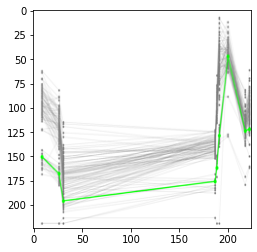

In [27]:
showImg(train_img[0])

### Normalization

In [31]:
# Find the shape of input images and create the variable input_shape
nRows,nCols,nDims = train_img.shape[1:]
input_shape = (nRows, nCols, nDims)

In [26]:
# Change to float datatype
train_img = train_img.astype('float32')
test_img = test_img.astype('float32')

# Scale the data to lie between 0 to 1
train_img /= 255
test_img /= 255

# Change the labels from integer to categorical data
train_labels_one_hot = to_categorical(train_label)
test_labels_one_hot = to_categorical(test_label)

In [34]:
# Find the unique numbers from the train labels
classes = np.unique(train_label)
nClasses = len(classes)
print('Total number of outputs : ', nClasses)
print('Output classes : ', classes)

Total number of outputs :  2
Output classes :  [0 1]


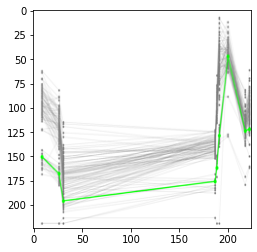

In [29]:
showImg(train_img[0])

### Train deep nerual network model

In [39]:
model1 = createModel()
batch_size = 50
epochs = 50
model1.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

model1.summary()

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20)
mc = ModelCheckpoint('best_model.h5', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)
history = model1.fit(train_img, train_labels_one_hot, batch_size=batch_size, epochs=epochs, verbose=1, 
                   validation_data=(test_img, test_labels_one_hot), callbacks=[es, mc])
model1.evaluate(test_data, test_labels_one_hot)

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_24 (Conv2D)           (None, 224, 224, 32)      896       
_________________________________________________________________
conv2d_25 (Conv2D)           (None, 222, 222, 32)      9248      
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 111, 111, 32)      0         
_________________________________________________________________
dropout_16 (Dropout)         (None, 111, 111, 32)      0         
_________________________________________________________________
conv2d_26 (Conv2D)           (None, 111, 111, 64)      18496     
_________________________________________________________________
conv2d_27 (Conv2D)           (None, 109, 109, 64)      36928     
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 54, 54, 64)       

ResourceExhaustedError:  OOM when allocating tensor with shape[50,32,224,224] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[node gradient_tape/sequential_5/conv2d_25/Conv2DBackpropInput (defined at <ipython-input-39-6dc0ba9c9d41>:10) ]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.
 [Op:__inference_train_function_9825]

Function call stack:
train_function


In [ ]:
plt.figure(figsize=[8,6])
plt.plot(history.history['loss'],'r',linewidth=3.0)
plt.plot(history.history['val_loss'],'b',linewidth=3.0)
plt.legend(['Training loss', 'Validation Loss'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Loss',fontsize=16)
plt.title('Loss Curves',fontsize=16)

In [ ]:
plt.figure(figsize=[8,6])
plt.plot(history.history['acc'],'r',linewidth=3.0)
plt.plot(history.history['val_acc'],'b',linewidth=3.0)
plt.legend(['Training Accuracy', 'Validation Accuracy'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Accuracy',fontsize=16)
plt.title('Accuracy Curves',fontsize=16)

## Reference:
- load image: https://keras.io/api/preprocessing/image/#load_img-function
- Model example: https://towardsdatascience.com/covolutional-neural-network-cb0883dd6529
- https://zhuanlan.zhihu.com/p/51889181